In [1]:
from lib.functions0 import *
from lib.utility import *
import numpy as np
from scipy.linalg import expm
from qiskit.utils.mitigation.fitters import CompleteMeasFitter
from qiskit.ignis.mitigation.measurement import  complete_meas_cal
from qiskit import Aer, assemble, QuantumCircuit, QuantumRegister, ClassicalRegister, IBMQ, transpile, execute
from qiskit.providers.aer import AerSimulator, QasmSimulator
from qiskit.opflow import Zero, One, I, X, Y, Z
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import state_fidelity
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
IBMQ.load_account()

provider = IBMQ.get_provider(hub='ibm-q-community',
                            group='ibmquantumawards', 
                            project='open-science-22')
backend_sim_jakarta = QasmSimulator.from_backend(provider.get_backend('ibmq_jakarta'))
backend_real_jakarta = provider.get_backend('ibmq_jakarta')
backend_sim = Aer.get_backend('qasm_simulator')

#provider = IBMQ.get_provider(group='open', project='main')
#backend_real_belem = provider.get_backend('ibmq_lima')



In [2]:
import qiskit
qiskit.utils.mitigation.fitters.__file__

'/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/utils/mitigation/fitters.py'

In [3]:
n_steps=51
time=np.pi
#initial_state={"110": 1}
#shots = 20000
backend = backend_sim_jakarta

X = np.array([[0,1],[1,0]])  #defining the pauli matrices
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])
Id = np.eye(2)

# defining the hamiltonian divided in: 
#       - H1: first two qubits interactions.
#       - H2: second two qubits interactions.

H1 = np.kron(X, np.kron(X,Id)) + np.kron(Y, np.kron(Y,Id)) + np.kron(Z, np.kron(Z,Id)) 
H2 = np.kron(Id, np.kron(X,X)) + np.kron(Id, np.kron(Y,Y)) + np.kron(Id, np.kron(Z,Z)) 

# building numerically the trotter step matrix, and the whole operator (trotter step)^n_steps.

trotter_step_matrix_= expm(-time/n_steps*H1*1j).dot(expm(-time/n_steps*H2*1j))
trotterized = np.linalg.matrix_power(trotter_step_matrix_, n_steps)
Matrix(trotterized).n(3, chop=True)

Matrix([
[1.0,                     0,                     0,                     0,                     0,                     0,                     0,   0],
[  0,       1.0 + 0.00395*I,  0.000758 + 0.00395*I,                     0, -0.000711 - 0.00791*I,                     0,                     0,   0],
[  0, -0.000711 + 0.00395*I,       1.0 - 0.00791*I,                     0,  0.000758 + 0.00395*I,                     0,                     0,   0],
[  0,                     0,                     0,       1.0 + 0.00395*I,                     0, -0.000711 + 0.00395*I,  0.000758 - 0.00791*I,   0],
[  0,  0.000758 - 0.00791*I, -0.000711 + 0.00395*I,                     0,       1.0 + 0.00395*I,                     0,                     0,   0],
[  0,                     0,                     0,  0.000758 + 0.00395*I,                     0,       1.0 - 0.00791*I, -0.000711 + 0.00395*I,   0],
[  0,                     0,                     0, -0.000711 - 0.00791*I,                 

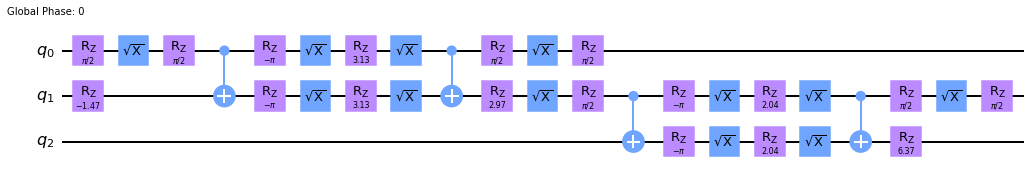

In [4]:
# phase_1_1, phase_2_1, phase_1_2, phase_2_2, a1, a2 = get_gates_parameters(trotterized, initial_state={"110": 1.0})

A0 = trotterized[3, 6]
A1 = trotterized[5, 6]
A2 = trotterized[6, 6]

r1=float(atan2(im(A0),re(A0))+atan2(im(A2),re(A2)))/2
r2=0
f1=float(atan2(im(A2),re(A2))-atan2(im(A1),re(A1))-np.pi)/2
f2=float((atan2(im(A2),re(A2))-atan2(im(A0),re(A0)))/2-f1)
a1=float(acos(abs(A2)))
a2=float(acos(abs(A1)/sin(a1)))

M1_qc = fixed_magnetization_two_qubit_gate(r1,f1,a1)
M2_qc = fixed_magnetization_two_qubit_gate(r2,f2,a2)

qr_U = QuantumRegister(3 ,name="q")
qc_U = QuantumCircuit(qr_U, name="U")

qc_U.append(M1_qc, [qr_U[0],qr_U[1]])
qc_U.append(M2_qc, [qr_U[1],qr_U[2]])

qc_U=transpile(qc_U, basis_gates=["cx","rz","x","sx"])
qc_U.draw(output="mpl")

In [5]:
U_ideal=matrix_from_circuit(qc_U, type="numpy")
Matrix(U_ideal)

Matrix([
[     0.999992179805683 - 0.00395478538974172*I, -5.22461232477368e-18 - 7.14007397668687e-17*I, -3.85148865432965e-17 - 2.86543966509416e-17*I,   -3.1898594549222e-20 - 4.1610264796053e-19*I, -1.2849060558932e-16 + 5.74560837443469e-17*I, 3.11618388111271e-20 + 3.65078782992289e-19*I, -1.82244576866957e-17 - 1.20629290820641e-18*I,                   4.51698e-35 - 6.256567e-34*I],
[ 6.46958575865653e-17 - 1.81265269388825e-17*I,      0.999952541508251 - 0.00395462862755608*I,  -0.000849703333802708 + 0.00886304957973318*I,   -5.24190486308785e-19 - 2.814249171752e-17*I,              -6.4951512e-33 + 5.2410596e-33*I, -1.28987326187191e-16 + 5.9024445250194e-17*I,  -3.77201276536254e-19 - 5.0403771662823e-19*I, -1.60299155196875e-17 + 4.26134262710906e-19*I],
[-1.56763563514424e-17 - 6.18916885422184e-17*I,   0.000710804473723417 + 0.00395462862755944*I,       0.449873050253018 - 0.0353008317318588*I, -3.78958226439293e-18 - 4.35244064244975e-17*I,     -0.892378557787717 + 0.003

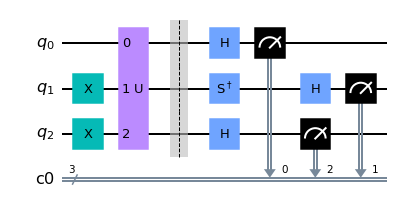

In [6]:
qr_evo = QuantumRegister(3, name="q")
qc_evo = QuantumCircuit(qr_evo, name="U")

qc_evo.x([qr_evo[1],qr_evo[2]])
qc_evo.append(qc_U, qr_evo)

qcs_tomo = state_tomography_circuits(qc_evo, qr_evo)
qcs_tomo[3].draw(output="mpl")

In [7]:
qr_cal = QuantumRegister(3)
cal_circ, state_labels = complete_meas_cal(qubit_list=[0,1,2], qr=qr_cal, circlabel='mcal')

In [8]:
cal_circ[0].draw()

░ ┌─┐      
q34_0: ─░─┤M├──────
        ░ └╥┘┌─┐   
q34_1: ─░──╫─┤M├───
        ░  ║ └╥┘┌─┐
q34_2: ─░──╫──╫─┤M├
        ░  ║  ║ └╥┘
 c1: 3/════╩══╩══╩═
           0  1  2

In [9]:
state_labels

['000', '001', '010', '011', '100', '101', '110', '111']

In [10]:
calib_circuits_identity = []
calib_circuits_itself = []

for i in state_labels:

    cr_cal_itself = ClassicalRegister(3)
    qr_cal_itself = QuantumRegister(3)
    qc_cal_itself = QuantumCircuit(qr_cal_itself, cr_cal_itself, name=f"mcalcal_{i}")

    cr_cal_id = ClassicalRegister(3)
    qr_cal_id = QuantumRegister(3)
    qc_cal_id = QuantumCircuit(qr_cal_id, cr_cal_id, name=f"mcalcal_{i}")

    qc_cal_id.append(qc_U, qr_cal_id)

    for k in range(3):
        if i[::-1][k] == "1":
            qc_cal_itself.x(qr_cal_itself[k])
            qc_cal_id.x(qr_cal_id[k])
        
    qc_cal_itself.append(qc_U, qr_cal_itself)
    
    qc_cal_id.measure(qr_cal_id, cr_cal_id)
    qc_cal_itself.measure(qr_cal_itself, cr_cal_itself)

    calib_circuits_identity.append(qc_cal_id)
    calib_circuits_itself.append(qc_cal_itself)

In [11]:
calib_circuits_identity[3].draw()

┌────┐┌───┐┌─┐   
q42_0: ┤0   ├┤ X ├┤M├───
       │    │├───┤└╥┘┌─┐
q42_1: ┤1 U ├┤ X ├─╫─┤M├
       │    │└┬─┬┘ ║ └╥┘
q42_2: ┤2   ├─┤M├──╫──╫─
       └────┘ └╥┘  ║  ║ 
 c9: 3/════════╩═══╩══╩═
               2   0  1

In [12]:
calib_circuits_itself[1].draw()

┌───┐┌────┐┌─┐      
q37_0: ┤ X ├┤0   ├┤M├──────
       └───┘│    │└╥┘┌─┐   
q37_1: ─────┤1 U ├─╫─┤M├───
            │    │ ║ └╥┘┌─┐
q37_2: ─────┤2   ├─╫──╫─┤M├
            └────┘ ║  ║ └╥┘
 c4: 3/════════════╩══╩══╩═
                   0  1  2

In [13]:
job_tomo=execute(qcs_tomo, backend, shots=shots, initial_layout=[0,1,2])

job_cal_our_identity=execute(calib_circuits_identity, backend = backend, shots=shots, initial_layout=[0,1,2])

job_cal_our_itself=execute(calib_circuits_itself, backend = backend, shots=shots, initial_layout=[0,1,2])

job_cal_qiskit=execute(cal_circ, backend, shots=shots, initial_layout=[0,1,2])

NameError: name 'shots' is not defined

In [ ]:
qiskit_raw_cal = deepcopy(job_cal_qiskit.result().get_counts())

In [14]:
tomo_id = "62508685a5d4ee324577dadb"
identity_id = "62508687cfe45cb34ce5b0bc"
itself_id = "6250868873968c540007c03c"
qiskit_id = "62508689fdf3770e2b56ffe5"

job_tomo = backend_real_jakarta.retrieve_job(tomo_id)
job_cal_our_identity = backend_real_jakarta.retrieve_job(identity_id)
job_cal_our_itself = backend_real_jakarta.retrieve_job(itself_id)
job_cal_qiskit = backend_real_jakarta.retrieve_job(qiskit_id)


# Mitigation:

    - building the calibration matrices

In [15]:
meas_fitter_our_identity = CompleteMeasFitter(job_cal_our_identity.result(), state_labels=state_labels)
meas_fitter_our_itself = CompleteMeasFitter(job_cal_our_itself.result(), state_labels=state_labels)
meas_fitter_qiskit = CompleteMeasFitter(job_cal_qiskit.result(), state_labels=state_labels)

In [16]:
Matrix(meas_fitter_qiskit.cal_matrix).n(3, chop=True)

Matrix([
[   0.939,   0.0543,   0.0492,  0.00297,   0.0423,  0.00284,  0.00231, 0.000156],
[  0.0232,    0.908,  0.00128,   0.0507, 0.000875,   0.0415,        0,  0.00241],
[  0.0149, 0.000906,    0.907,   0.0539, 0.000531,  9.37e-5,   0.0418,  0.00244],
[0.000375,   0.0158,   0.0205,    0.871,        0, 0.000813, 0.000875,    0.039],
[  0.0218,  0.00106, 0.000969, 0.000156,    0.921,   0.0529,    0.052,  0.00269],
[0.000594,     0.02,  6.25e-5,  0.00122,     0.02,    0.888, 0.000906,   0.0461],
[0.000375,  6.25e-5,   0.0204,  0.00109,   0.0152, 0.000813,    0.884,   0.0518],
[       0, 0.000313, 0.000313,   0.0192, 0.000563,   0.0132,   0.0182,    0.855]])

In [ ]:
#calib = np.linalg.multi_dot([migigated_qiskit, np.linalg.inv(not_migigated_qiskit)])
#Matrix(calib).n(2, chop=True)

In [18]:
U_tilde_identity=meas_fitter_our_identity.cal_matrix
U_tilde_itself=meas_fitter_our_itself.cal_matrix
U_tilde_qiskit=meas_fitter_qiskit.cal_matrix

In [19]:
def matrix_from_cirquit(qc, phase=0, type="sympy"):

    backend = Aer.get_backend('unitary_simulator')
    job = execute(qc, backend, shots=32000)
    result = job.result()
    A=result.get_unitary(qc, decimals=10)*np.exp(1j*phase)
    if type=="sympy":
        return Matrix(A)
    else:
        return A

In [20]:
qr_basi = QuantumRegister(3)
qc_basi = QuantumCircuit(qr_basi)

qcs_basis = state_tomography_circuits(qc_basi, qr_basi)

qcs_basis[0].remove_final_measurements()

qcs_basis[16].draw()

░ ┌─────┐ ┌───┐      ┌─┐   
q51_0: ─░─┤ Sdg ├─┤ H ├──────┤M├───
        ░ └─┬─┬─┘ └───┘      └╥┘   
q51_1: ─░───┤M├───────────────╫────
        ░   └╥┘  ┌─────┐┌───┐ ║ ┌─┐
q51_2: ─░────╫───┤ Sdg ├┤ H ├─╫─┤M├
        ░    ║   └─────┘└───┘ ║ └╥┘
c18: 3/══════╩════════════════╩══╩═
             1                0  2

In [21]:
C_matrices_itself = []
C_matrices_identity = []

U_ideal_inv = np.linalg.inv(U_ideal)
U_ideal_inv_abs = np.abs(U_ideal_inv)**2

U_ideal_abs = np.abs(U_ideal)**2
#print(type(U_ideal_abs))
#U_ideal_abs = np.asarray(Matrix(U_ideal_abs).n(10, chop=True), dtype='float64')
#print(type(U_ideal_abs))
U_ideal_abs_inv = np.linalg.inv(U_ideal_abs)

C_itself = np.dot(U_tilde_itself, U_ideal_abs_inv)
C_identity = U_tilde_identity

In [22]:
Matrix(U_ideal_abs).n(3, chop=True)
np.linalg.det(U_ideal_abs)

0.3511865140160771

In [23]:
Matrix(np.dot(U_ideal_abs,np.linalg.inv(U_ideal_abs))).n(3, chop=True)

Matrix([
[1.0,   0,   0,   0,   0,   0,   0,   0],
[  0, 1.0,   0,   0,   0,   0,   0,   0],
[  0,   0, 1.0,   0,   0,   0,   0,   0],
[  0,   0,   0, 1.0,   0,   0,   0,   0],
[  0,   0,   0,   0, 1.0,   0,   0,   0],
[  0,   0,   0,   0,   0, 1.0,   0,   0],
[  0,   0,   0,   0,   0,   0, 1.0,   0],
[  0,   0,   0,   0,   0,   0,   0, 1.0]])

In [24]:
Matrix(U_ideal_abs_inv)

Matrix([
[                  1.0, -5.12558587663421e-33, -2.58262225696268e-32, -8.50194943460827e-38,  3.71093801624074e-33, -1.96954223858463e-37, -3.33612439348309e-34,  4.05621716890631e-66],
[-4.51394572104693e-33,      1.00007928821486,   2.72427614051007e-5, -2.67675394886299e-32, -0.000106530976261911,  5.85113538741965e-33,  2.01215027465084e-36, -2.57160170132456e-34],
[-6.77500185486476e-33,  -7.92882148568106e-5,    -0.343618802418781,  3.28123234550616e-33,      1.34369809063364, -1.26095133726307e-32, -1.02547264360376e-32,  2.03881542817167e-38],
[-7.08794478886572e-38,  -6.9784525820494e-33,  3.77543865869088e-33,    -0.343591559657376, -1.47635975717203e-32,      1.34359155965738,  4.25456584581495e-21,  -3.9862630348798e-33],
[ -3.3862538176961e-33,  4.03278417649242e-65,      1.34359155965738, -6.98680928488709e-33,    -0.343591559657376,  1.78671016646991e-33, -6.33293895819888e-33, -1.74158933973981e-37],
[ 2.04086728796752e-38, -7.75755675052784e-33,  -6.0264369041

In [25]:
Matrix(C_itself)

Matrix([
[0.87196875,  0.0789706454838864,   0.0488490403088494, 0.00312956912563146,   0.0566490642072641,   0.0109328788414775,   0.005375052032891,   0.001625],
[     0.043,   0.839159365953307, 0.000259228539365487,   0.043346179616725,   0.0143314055073271,   0.0591574304748077,  0.0010276399084673, 0.00584375],
[0.01596875, 0.00370198797582793,    0.764984086499753,  0.0971848591624002,   0.0745326755244193, 0.000379533843729489,  0.0535918569938703, 0.02465625],
[ 0.0039375,  0.0145940820193997,    0.062806434905701,   0.737548185210496, -0.00299426692510076,   0.0663412670120981,  0.0243605477774052, 0.05753125],
[ 0.0294375, 0.00776267231247592,   0.0794401398578647, 0.00666070424497192,    0.778703437829659,   0.0669299683811889,  0.0577530773738391, 0.00621875],
[0.00840625,  0.0264994846266034,  0.00234914046736696,  0.0773625825482996,   0.0408388749060296,    0.756372874965224, 0.00488954248647564, 0.05590625],
[0.01140625,  0.0207189036209163,    0.031797346017031, 0.003

In [26]:
np.linalg.det(np.abs(trotterized)**2)

0.9996182309285547

In [27]:

for base in qcs_basis:
    
    '''
    base.remove_final_measurements()

    base_matrix = np.matrix(matrix_from_cirquit(base, type="numpy"))
    base_matrix_H = base_matrix.getH()

    C_aus_itself = np.linalg.multi_dot([U_tilde_qiskit, base_matrix, np.linalg.inv(U_tilde_qiskit), C_itself,  base_matrix_H])
    #C_aus_itself = np.linalg.multi_dot([base_matrix, U_tilde_qiskit, np.linalg.inv(U_tilde_qiskit), C_itself])
    C_aus_identity = np.dot(base_matrix, C_identity).dot(base_matrix_H)

    C_matrices_identity.append(np.asarray(C_aus_identity))
    C_matrices_itself.append(np.asarray(C_aus_itself))
    '''

    base.remove_final_measurements()

    base_matrix_amplitudes = matrix_from_cirquit(base, type="numpy")
    base_matrix_amplitudes_inverse = np.linalg.inv(base_matrix_amplitudes)
    
    base_matrix = np.abs(base_matrix_amplitudes)**2
    base_matrix_inverse = np.abs(base_matrix_amplitudes_inverse)**2

    C_aus_itself = np.linalg.multi_dot([base_matrix, C_itself,  base_matrix_inverse])
    #C_aus_itself = np.linalg.multi_dot([U_tilde_qiskit, base_matrix, np.linalg.inv(U_tilde_qiskit), C_itself,  base_matrix_inverse])
    #C_aus_itself = np.linalg.multi_dot([U_tilde_qiskit, base_matrix, np.linalg.inv(U_tilde_qiskit), C_itself,  np.transpose(base_matrix)])
    

    #C_aus_identity = np.linalg.multi_dot([U_tilde_qiskit, base_matrix, np.linalg.inv(U_tilde_qiskit), C_identity,  base_matrix_inverse])
    C_aus_identity = np.linalg.multi_dot([base_matrix, C_identity, base_matrix_inverse])

    C_matrices_identity.append(np.asarray(C_aus_identity))
    C_matrices_itself.append(np.asarray(C_aus_itself))

In [28]:
from copy import deepcopy

meas_fitters_identity = []
meas_fitters_itself = []

for C_new in C_matrices_identity:
    meas_fitter_our_aus = deepcopy(meas_fitter_our_identity)
    meas_fitter_our_aus._tens_fitt.cal_matrices[0]=C_new

    meas_fitters_identity.append(meas_fitter_our_aus)

for C_new in C_matrices_itself:
    meas_fitter_our_aus = deepcopy(meas_fitter_our_itself)
    meas_fitter_our_aus._tens_fitt.cal_matrices[0]=C_new

    meas_fitters_itself.append(meas_fitter_our_aus)

In [29]:
target_state = (One^One^Zero).to_matrix()
#target_state = (Zero^One^One).to_matrix()


fids=np.zeros(4)

raw_res=deepcopy(job_tomo.result())
qiskit_res=deepcopy(raw_res)
identity_res=deepcopy(raw_res)
itself_res=deepcopy(raw_res)

In [30]:
raw_res.get_counts(-1)

{'000': 174,
 '001': 47,
 '010': 1790,
 '011': 518,
 '100': 1802,
 '101': 130,
 '110': 26306,
 '111': 1233}

In [31]:
for i in range(27):

    old_counts=raw_res.get_counts(i)
    new_counts_qiskit = meas_fitter_qiskit.filter.apply(old_counts, method="least_squares")
    qiskit_res.results[i].data.counts = new_counts_qiskit

    old_counts=raw_res.get_counts(i)
    
    new_counts_id = meas_fitters_identity[i].filter.apply(old_counts, method="least_squares")
    identity_res.results[i].data.counts = new_counts_id

    new_counts_it = meas_fitters_itself[i].filter.apply(old_counts, method="least_squares")
    itself_res.results[i].data.counts = new_counts_it

In [32]:
raw_res.get_counts(-1)

{'000': 174,
 '001': 47,
 '010': 1790,
 '011': 518,
 '100': 1802,
 '101': 130,
 '110': 26306,
 '111': 1233}

In [33]:
itself_res.get_counts(-1)

{'000': 2.6949112351503256e-10,
 '001': 2.19917710471448e-09,
 '010': 8.72395748812009e-09,
 '110': 32000.0}

In [34]:
identity_res.get_counts(-1)

{'011': 2.4446533859304384e-08,
 '100': 1.66473994322772e-08,
 '101': 5.167290878017733e-09,
 '110': 31999.99999995646,
 '111': 9.905301724847331e-10}

In [35]:
fids[0] = fidelity_count(raw_res, qcs_tomo, target_state)
fids[1] = fidelity_count(qiskit_res, qcs_tomo, target_state)
fids[2] = fidelity_count(identity_res, qcs_tomo, target_state)
fids[3] = fidelity_count(itself_res, qcs_tomo, target_state)

fids

array([0.81782616, 0.92249187, 0.9999839 , 0.99999826])

In [36]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})  # enlarge matplotlib fonts

# Import qubit states Zero (|0>) and One (|1>), and Pauli operators (X, Y, Z)
from qiskit.opflow import Zero, One, I, X, Y, Z

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Returns the matrix representation of the XXX Heisenberg model for 3 spin-1/2 particles in a line
def H_heis3():
    # Interactions (I is the identity matrix; X, Y, and Z are Pauli matricies; ^ is a tensor product)
    XXs = (I^X^X) + (X^X^I)
    YYs = (I^Y^Y) + (Y^Y^I)
    ZZs = (I^Z^Z) + (Z^Z^I)
    
    # Sum interactions
    H = XXs + YYs + ZZs
    
    # Return Hamiltonian
    return H

# Returns the matrix representation of U_heis3(t) for a given time t assuming an XXX Heisenberg Hamiltonian for 3 spins-1/2 particles in a line
def U_heis3(t):
    # Compute XXX Hamiltonian for 3 spins in a line
    H = H_heis3()
    
    # Return the exponential of -i multipled by time t multipled by the 3 spin XXX Heisenberg Hamilonian 
    return (t * H).exp_i()

In [37]:
initial_state = One^One^Zero

#((initial_state @ U_heis3(float(time)) @ initial_state).eval())**2
np.abs((~initial_state @ U_heis3(float(time)) @ initial_state).eval())**2

1.0000000000000004

In [38]:
matrix=1/np.sqrt(2)*np.array([[1,1],[1,-1]])
np.linalg.inv(matrix)

array([[ 0.70710678,  0.70710678],
       [ 0.70710678, -0.70710678]])